# Test One for the Quantum SRNN

This is a notebook for testing the quantum SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import qutip as qt

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from QuantumModels.QuantumSRNNs import QuantumSRNN
from QuantumModels.QuantumSRNNs import QuantumSystemFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
import GradientFreeOptimizers.Helpers as hp

## Test One

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='QuantumSRNNTest1.csv'

In [6]:
'''
hmap=HenonMapDataGen(savepath=savepath)
hmap(1000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 1000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.0924795117387862, 0.060895690863037484]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=10
batchSize=4

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,mask=0,shuffle=False)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Train Data Size: 76
X= tensor([[-0.6155,  0.7783, -0.0327,  1.2320, -1.1348, -0.4332,  0.3969,  0.6495,
          0.5284,  0.8039],
        [-0.0201,  1.2310, -1.1277, -0.4110,  0.4253,  0.6235,  0.5833,  0.7108,
          0.4677,  0.9069],
        [ 1.1430, -0.7706,  0.5116,  0.4024,  0.9268, -0.0819,  1.2687, -1.2779,
         -0.9055, -0.5313],
        [-0.1886,  1.2061, -1.0931, -0.3108,  0.5368,  0.5033,  0.8064,  0.2406,
          1.1609, -0.8144]])
Y= tensor([[ 0.7783, -0.0327,  1.2320, -1.1348, -0.4332,  0.3969,  0.6495,  0.5284,
          0.8039,  0.2538],
        [ 1.2310, -1.1277, -0.4110,  0.4253,  0.6235,  0.5833,  0.7108,  0.4677,
          0.9069, -0.0112],
        [-0.7706,  0.5116,  0.4024,  0.9268, -0.0819,  1.2687, -1.2779, -0.9055,
         -0.5313,  0.3332],
        [ 1.2061, -1.0931, -0.3108,  0.5368,  0.5033,  0.8064,  0.2406,  1.1609,
         -0.8144,  0.4197]])


In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Test Data Size: 16
X= tensor([[-0.6889,  0.6724,  0.1604,  1.1657, -0.8543,  0.3280,  0.5931,  0.6060,
          0.6639,  0.5648],
        [-0.3276,  1.1234, -0.8650,  0.2895,  0.6231,  0.5432,  0.7738,  0.3246,
          1.0846, -0.5495],
        [ 1.0939, -0.5810,  0.8555, -0.1990,  1.2012, -1.0798, -0.2721,  0.5724,
          0.4597,  0.8759],
        [ 0.6725,  0.4262,  0.9474, -0.1287,  1.2610, -1.2649, -0.8615, -0.4186,
          0.4963,  0.5296]])
Y= tensor([[ 0.6724,  0.1604,  1.1657, -0.8543,  0.3280,  0.5931,  0.6060,  0.6639,
          0.5648,  0.7526],
        [ 1.1234, -0.8650,  0.2895,  0.6231,  0.5432,  0.7738,  0.3246,  1.0846,
         -0.5495,  0.9026],
        [-0.5810,  0.8555, -0.1990,  1.2012, -1.0798, -0.2721,  0.5724,  0.4597,
          0.8759,  0.0638],
        [ 0.4262,  0.9474, -0.1287,  1.2610, -1.2649, -0.8615, -0.4186,  0.4963,
          0.5296,  0.7561]])


### Define the SRNN

#### Parameters

In [13]:
inputSize=outputSize=1
qubits=4

In [14]:
activation=[0,2]
inputQubits=outputQubits=[i for i in range(qubits)]
interQPairs=[[i,j] for i in range(qubits) for j in range(i+1,qubits)]
inactive=['WIn','DeltaIn','J']
print('Input Qubits:',inputQubits)
print('Output Qubits:',outputQubits)
print('InterQPairs=',interQPairs)

Input Qubits: [0, 1, 2, 3]
Output Qubits: [0, 1, 2, 3]
InterQPairs= [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]


In [15]:
measEffect=True

#### Get neccesary functions

In [16]:
srnnTestSup=QuantumSystemFunction()

In [17]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [18]:
init_rnn_state=srnnTestSup.get_init_state_fun(activation=activation)
get_params=srnnTestSup.get_get_params_fun(inputQubits=inputQubits,outputQubits=outputQubits,interQPairs=interQPairs,inactive=inactive)
rnn=srnnTestSup.get_forward_fn_fun(measEffect=measEffect)
predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [19]:
net=QuantumSRNN(inputSize,qubits,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [20]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0][0].shape

(torch.Size([40, 1]), 1, (16, 16))

In [21]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0925],
        [0.0609]])
preY= [tensor([0.0925]), tensor([0.0609]), tensor([1.0226]), tensor([-0.4456]), tensor([1.0288]), tensor([-0.6155]), tensor([0.7783]), tensor([-0.0327]), tensor([1.2320]), tensor([-1.1348]), tensor([-0.4332])]


In [22]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0925), tensor(0.0609), tensor(0.0004), tensor(0.0003), tensor(0.0003), tensor(0.0003), tensor(0.0003)]


### Train the network

#### Parameters

In [23]:
num_epochs, lr = 10, 0.1

#### Loss function

In [24]:
lossFunc=GradFreeMSELoss(net)

In [25]:
print(net.params)

[tensor([[-7.2694e-03],
        [ 9.8756e-03],
        [ 8.5127e-05],
        [ 2.3948e-03]], requires_grad=True), tensor([0.], requires_grad=True)]


#### Trainer

In [26]:
trainer = torch.optim.SGD(net.params, lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(trainer,step_size=100,gamma=0.1)

In [27]:
print(net.params[0].is_leaf)
print(net.params[1].is_leaf)

True
True


#### Initial loss

In [28]:
l_epochs=[]
train_l=QuantumSystemFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=QuantumSystemFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5813004368229916
Initial Test Loss: 0.5653335213661194


#### Training

TestLoss 0.482738, 40.629737 point/s
Prediction:
 [tensor(0.0925), tensor(0.0609), tensor(0.2379), tensor(0.2379), tensor(0.2379), tensor(0.2379), tensor(0.2379), tensor(0.2379), tensor(0.2379), tensor(0.2379), tensor(0.2379)]
Answer:
 [tensor([0.0925]), tensor([0.0609]), tensor([1.0226]), tensor([-0.4456]), tensor([1.0288]), tensor([-0.6155]), tensor([0.7783]), tensor([-0.0327]), tensor([1.2320]), tensor([-1.1348]), tensor([-0.4332])]


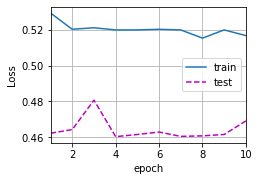

In [29]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'],xlim=[1,num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    trainLoss, speed = QuantumSystemFunction.train_epoch(
        net, trainIter, lossFunc, trainer, False)
    testLoss=QuantumSystemFunction.evaluate_accuracy(net, testIter, lossFunc, False)
    if (epoch + 1) % 1 == 0:
        print(predict(preX))
        animator.add(epoch + 1, [trainLoss,testLoss])
    l_epochs.append([trainLoss,testLoss])
    scheduler.step()
testLoss=QuantumSystemFunction.evaluate_accuracy(net, testIter, lossFunc, False)
print(f'TestLoss {testLoss:f}, {speed:f} point/s')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

### Visualize the performance

#### One Step Prediction

In [30]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))



X= tensor([[-0.6889,  0.6724,  0.1604,  1.1657, -0.8543,  0.3280,  0.5931,  0.6060,
          0.6639,  0.5648],
        [-0.3276,  1.1234, -0.8650,  0.2895,  0.6231,  0.5432,  0.7738,  0.3246,
          1.0846, -0.5495],
        [ 1.0939, -0.5810,  0.8555, -0.1990,  1.2012, -1.0798, -0.2721,  0.5724,
          0.4597,  0.8759],
        [ 0.6725,  0.4262,  0.9474, -0.1287,  1.2610, -1.2649, -0.8615, -0.4186,
          0.4963,  0.5296]])
Prediction= tensor([0.2387, 0.2386, 0.2384, 0.2385, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379,
        0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379,
        0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379,
        0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379, 0.2379,
        0.2379, 0.2379, 0.2379, 0.2379])
Y= tensor([ 0.6724,  1.1234, -0.5810,  0.4262,  0.1604, -0.8650,  0.8555,  0.9474,
         1.1657,  0.2895, -0.1990, -0.1287, -0.8543,  0.6231,  1.2012,  1.2610,
         0.3280,  0.5432

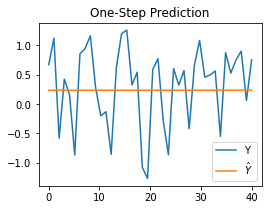

In [31]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [32]:
prefixSize=10
totalSize=40
testShift=int(len(hmap)*(1-testSetRatio))

In [33]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

40

In [34]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

40

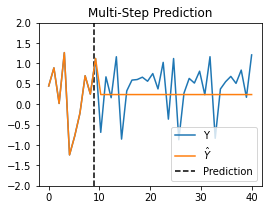

In [35]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();

In [36]:
print(net.params)

[tensor([[0.0096],
        [0.0283],
        [0.0170],
        [0.0208]], requires_grad=True), tensor([0.2329], requires_grad=True)]


In [37]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0][0].shape

(torch.Size([40, 1]), 1, (16, 16))

In [46]:
I=[]
for i in range(qubits):
    I.append(qt.qeye(2))
I=qt.tensor(I)
print(qt.expect(I,newState[0][0]))

<class 'qutip.qobj.Qobj'>
1.0000000000000007


In [60]:
sigma=[]
j=1
for i in range(qubits):
    if i==j:
        sigma.append(qt.sigmaz())
    else:
        sigma.append(qt.qeye(2))
sigma=qt.tensor(sigma)
print(qt.expect(sigma,newState[0][0]))

0.06651291215917689


# End of the test